The German Credit data set is a publically available data set downloaded from the UCI Machine Learning Repository. The data contains data on 20 variables and the classification whether an applicant is considered a Good or a Bad credit risk for 1000 loan applicants.

### [Data Source](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))
- Professor Dr. Hans Hofmann  
- Institut f"ur Statistik und "Okonometrie  
- Universit"at Hamburg  
- FB Wirtschaftswissenschaften  
- Von-Melle-Park 5    
- 2000 Hamburg 13

### Benchmark
![Credit Risk Classification: Faster Machine Learning with Intel Optimized Packages](https://i.imgur.com/nL1l7WI.png)

according to [1] the best model is Random Forest with balanced feature selection data. it's has Accuracy 82%, Precision 84%, Recall 82% and F1-Score 81%. 

<br>


The goal of this kernel is to beat The benchmark with  :
- Convert dataset to Machine Learning friendly (Feature Engginering)
- Develop XGBoost model to predict whether a loan is a good or bad risk.
- Find the Best parameter for XGBoost Model (Hyperparameter Tunning)
- Beat the Benchmark

# Table of Content

##1. Introduction
  - Import Library
  - Evaluation Function
  - XGBoost Model

##2. Preprocess
  - Importing Dataset
  - StandardScaler
  - Encoding Categorical Feature
  - Concate Transformed Dataset
  - Split Training Dataset
  - XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

<a id="Introduction"></a> <br>
# **1. Introduction:** 
- Import Library
- Evaluation Function
- XGBoost Model

### Import Library

In [29]:
#Importing necessary packages in Python 
%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd

from sklearn.datasets import make_classification 

### module moved...
### from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve 
###

#from sklearn.cross_validation import train_test_split 
#from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

from pprint import pprint 

import requests

### Evaluation Function


In [30]:
# Function for evaluation reports
def get_eval1(clf, X,y):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 

def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return  
  
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return


#### XGBoost Model

In [31]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import xgboost as xgb
from xgboost import XGBClassifier
#print('XGBoost v',xgb.__version__)

# fit, train and cross validate Decision Tree with training and test data 
def xgbclf(params, X_train, y_train,X_test, y_test):
  
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    model = XGBClassifier(**params).\
      fit(X_train, y_train, eval_set=eval_set, \
                  eval_metric='auc', early_stopping_rounds = 100, verbose=100)
        
    #print(model.best_ntree_limit)

    model.set_params(**{'n_estimators': model.best_ntree_limit})
    model.fit(X_train, y_train)
    #print(model,'\n')
    
    # Predict target variables y for test data
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit) #model.best_iteration
    #print(y_pred)
   
    # Get Cross Validation and Confusion matrix
    #get_eval(model, X_train, y_train)
    #get_eval2(model, X_train, y_train,X_test, y_test)
    
    # Create and print confusion matrix    
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    
    #y_pred = model.predict(X_test)
    print (classification_report(y_test,y_pred) )
    print ('\n')
    print ("Model Final Generalization Accuracy: %.6f" %accuracy_score(y_test,y_pred) )
    
    # Predict probabilities target variables y for test data
    y_pred_proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)[:,1] #model.best_iteration
    get_roc (y_test,y_pred_proba)
    return model

def plot_featureImportance(model, keys):
  importances = model.feature_importances_

  importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(keys)})
  importance_frame.sort_values(by = 'Importance', inplace = True)
  importance_frame.tail(10).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

<a id="Preprocess"></a> <br>
# **2. Preprocess** 
- Importing Dataset
- StandardScaler
- Encoding Categorical Feature
- Concate Transformed Dataset
- Split Training Dataset
- XGBoost  1a: Unbalance Dataset (Base Model: ROC_AUC:0.74)
- XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

### Import Dataset

OK let's get started. We'll download the data from the UCI website.

In [32]:
### file updated path
german_data = "https://raw.githubusercontent.com/neta-caspi/mlops-final-proj/main/data/german-credit/german-credit-data/german.data"
###

In [33]:
###
### file = '../input/germancreditdata/german.data'
file = german_data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
# r = requests.get(url, allow_redirects=True)
# open(file, 'wb').write(r.content)

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv(file, names = names, delimiter=' ')
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,residencesince,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,4,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,4,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,2,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,4,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,2,A123,28,A143,A152,2,A174,1,A191,A201,2


In [34]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

### StandardScaler

In [35]:
#numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

### Encoding Categorical Feature

Labelencoding to transform categorical to numerical, Enables better Visualization than one hot encoding

In [36]:
from collections import defaultdict

#categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


### Concate Transformed Dataset
append the dummy variable of the initial numerical variables numvars# append 

In [37]:
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)

print(data_clean.shape)

(1000, 62)


### Split Training Dataset

In [38]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)

In [39]:
X_train_clean.keys()

Index(['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'existingchecking_A11',
       'existingchecking_A12', 'existingchecking_A13', 'existingchecking_A14',
       'credithistory_A30', 'credithistory_A31', 'credithistory_A32',
       'credithistory_A33', 'credithistory_A34', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64',
       'savings_A65', 'employmentsince_A71', 'employmentsince_A72',
       'employmentsince_A73', 'employmentsince_A74', 'employmentsince_A75',
       'statussex_A91', 'statussex_A92', 'statussex_A93', 'statussex_A94',
       'otherdebtors_A101', 'otherdebtors_A102', 'otherdebtors_A103',
       'property_A121', 'property_A122', 'property_A123', 'property_A124',
       'otherinstallmentplans_A141', 'otherinstallmentplans_A

### XGBoost  1b: Unbalance Dataset (ROC_AUC:0.79)

[0]	validation_0-auc:0.788664	validation_1-auc:0.708258
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.893809	validation_1-auc:0.780803
Stopping. Best iteration:
[9]	validation_0-auc:0.873373	validation_1-auc:0.785611

[[ 23  36]
 [  5 136]]
              precision    recall  f1-score   support

           0       0.82      0.39      0.53        59
           1       0.79      0.96      0.87       141

    accuracy                           0.80       200
   macro avg       0.81      0.68      0.70       200
weighted avg       0.80      0.80      0.77       200



Model Final Generalization Accuracy: 0.795000


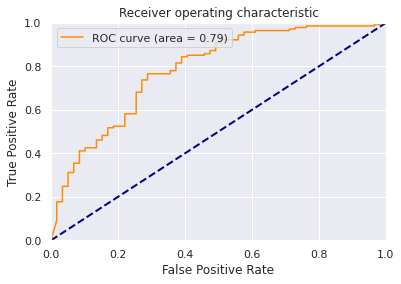

XGBClassifier(colsample_bytree=0.7, learning_rate=0.005, max_depth=8,
              min_child_weight=3, n_estimators=10, n_jobs=-1, subsample=0.555)

In [40]:
params={}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

xgbclf(params2, X_train_clean, y_train_clean, X_test_clean, y_test_clean)